In [8]:
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, RFE
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, plot_precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from tensorflow.keras.utils import to_categorical


In [9]:
data_df = pd.read_csv('(Radiomics+Clinical)_testing_copy.csv')
print(data_df .shape)

y_train = data_df['class']
class_list = list(y_train.unique())

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y_train)


(402, 2161)


In [10]:


# #### Sequential Foward Selection
def SFS_GS(X_train, y_train, X_test, y_test, model, param_grid, df):
    # Setting up the SFS
    sfs1 = SFS(estimator=model,
               k_features=X_train.shape[1],
               forward=True,
               floating=False,
               scoring='accuracy',
               cv=StratifiedKFold(5, shuffle=True, random_state=42))

    # Pipeline

    # we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"

    pipe = Pipeline([('sfs', sfs1),
                     ('model', model)])

    dict_1 = {'sfs__k_features': [30]}  # Testing

    dict_1.update(param_grid)

    gs = GridSearchCV(estimator=pipe,
                      param_grid=dict_1,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(3, shuffle=True, random_state=42),
                      verbose=3,
                      refit=True)

    print(pipe.get_params().keys())

    gs = gs.fit(X_train, y_train)

#     print(gs.best_estimator_.steps)

    y_score = gs.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(gs, X_test, y_test)

    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print("Model", gs.best_params_)
    print('score:', gs.best_score_)
    print("Best Model", gs.best_params_)
    print('Best score:', gs.best_score_)
    y_test_pred = gs.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    probs = gs.predict_proba(X_test_p)
    probs = probs[:, 1]
    ROC_AUC = roc_auc_score(y_test, probs)
    precison_scor = precision_score(y_test, y_test_pred)
    recall_scor = recall_score(y_test, y_test_pred)
    fpr, tpr, thresholds = roc_curve(y_testp, probs)
    print("\n Test Accuracy with best estimator: ", test_acc)
    print("\n Roc AUC with best estimator: ", ROC_AUC)
    print("\n Precision with best estimator: ", precison_scor)
    print("\n Recall with best estimator: ", recall_scor, "\n")

    l = [[test_acc, ROC_AUC, precison_scor, recall_scor]]
    table = tabulate(
        l, headers=['Accuracy', 'ROC_AUC', 'Precision', 'Recall'], tablefmt='orgtbl')

    print(table)

    cm = confusion_matrix(y_test, y_test_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(10, 4))
    fig.add_subplot(121)
#     plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')
    plt.tight_layout()

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig.add_subplot(122)
    plt.plot(fpr, tpr, color='C1', lw=3,
             label='ROC curve of radiomics (AUC = %0.2f)' % ROC_AUC)

    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(classification_report(y_test, y_test_pred, target_names=class_list))

    cols = gs.best_estimator_.steps[0][1].k_feature_idx_
    cols = list(cols)
    print(cols)
    pipe = df.iloc[:, cols].columns


#   print(df.iloc[:, cols].columns)

    return gs, pipe


In [11]:
model_SVC = SVC(gamma='scale', max_iter=5000, random_state=42)

param_grid_SVC = {'model__kernel': ('linear', 'rbf'),
                  'model__C': [5, 10]}

param_grid_SVC_nested_2 = {'selector__estimator__kernel': ['linear', 'rbf'],
                           'selector__estimator__C': [15]}

param_grid_SVC_test_2 = {
    'estimator__model__C': [0.5, 1, 5, 10]}


In [12]:

# Random Forest

# Number of trees in random forest
n_estimators = [10, 100, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 4, 6, 8, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

param_grid_RF = {'model__n_estimators': n_estimators,
                 'model__max_features': max_features,
                 'model__max_depth': max_depth,
                 'model__min_samples_split': min_samples_split,
                 'model__min_samples_leaf': min_samples_leaf,
                 'model__bootstrap': bootstrap}

param_grid_RF_2 = {'estimator__n_estimators': n_estimators,
                   'estimator__bootstrap': bootstrap}

model_RF = RandomForestClassifier(random_state=42)


param_grid_LR_nested = {'model__penalty': ['l1', 'l2'],
                        'model__C': [0.1, 1, 10, 100, 200]}

param_grid_LR = {'penalty': ['l1', 'l2'],
                 'C': [0.1, 1, 10, 100, 200]}

model_LR = LogisticRegression(multi_class='auto', random_state=42)

model_SVC = SVC(gamma='scale', probability=True,
                max_iter=5000, random_state=42)

param_grid_SVC = {'model__kernel': ('linear', 'rbf'),
                  'model__C': [0.3, 0.5, 1, 5, 10]}


dict_keys(['memory', 'steps', 'verbose', 'sfs', 'model', 'sfs__clone_estimator', 'sfs__cv', 'sfs__estimator__C', 'sfs__estimator__break_ties', 'sfs__estimator__cache_size', 'sfs__estimator__class_weight', 'sfs__estimator__coef0', 'sfs__estimator__decision_function_shape', 'sfs__estimator__degree', 'sfs__estimator__gamma', 'sfs__estimator__kernel', 'sfs__estimator__max_iter', 'sfs__estimator__probability', 'sfs__estimator__random_state', 'sfs__estimator__shrinking', 'sfs__estimator__tol', 'sfs__estimator__verbose', 'sfs__estimator', 'sfs__fixed_features', 'sfs__floating', 'sfs__forward', 'sfs__k_features', 'sfs__n_jobs', 'sfs__pre_dispatch', 'sfs__scoring', 'sfs__verbose', 'sfs__svc', 'sfs__svc__C', 'sfs__svc__break_ties', 'sfs__svc__cache_size', 'sfs__svc__class_weight', 'sfs__svc__coef0', 'sfs__svc__decision_function_shape', 'sfs__svc__degree', 'sfs__svc__gamma', 'sfs__svc__kernel', 'sfs__svc__max_iter', 'sfs__svc__probability', 'sfs__svc__random_state', 'sfs__svc__shrinking', 'sfs__s

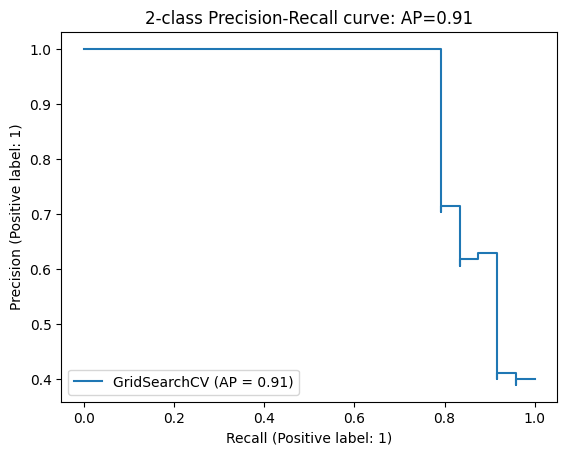

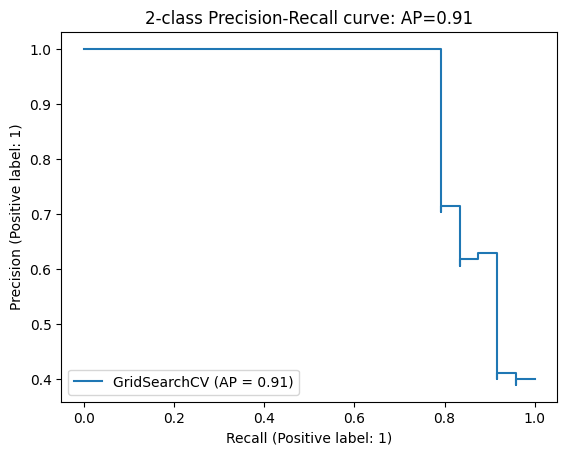

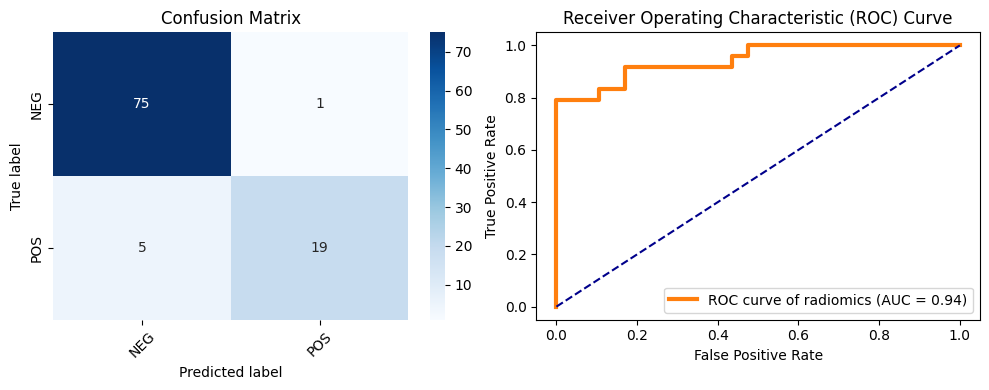

              precision    recall  f1-score   support

         NEG       0.94      0.99      0.96        76
         POS       0.95      0.79      0.86        24

    accuracy                           0.94       100
   macro avg       0.94      0.89      0.91       100
weighted avg       0.94      0.94      0.94       100

[3, 8, 9, 13, 23, 26, 31, 32, 36, 37, 38, 40, 53, 58, 60, 63, 66, 75, 80, 87, 108, 109, 112, 135, 141, 526, 776, 1046, 1257, 1448]


In [13]:

scaler = MinMaxScaler()

data_df = data_df.drop(columns=['class'])

X_sc = scaler.fit_transform(data_df)

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y_train)


X_train_p, X_test_p, y_trainp, y_testp = train_test_split(
    X_sc, y_enc, test_size=100, shuffle=True, stratify=y_train, random_state=42)
gs, pipi = SFS_GS(X_train_p, y_trainp, X_test_p, y_testp,
                  model_SVC, param_grid_SVC, data_df)
